<a href="https://colab.research.google.com/github/Joizra/Deep-Learning/blob/main/Image_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

1. Load and normalize training and test datasets using torchvision

In [ ]:
# Data Preprocessing
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
import ssl
import urllib.request

# Bypass SSL certificate verification (use with caution!)
ssl._create_default_https_context = ssl._create_unverified_context

# Create an opener that does not verify SSL certificates and install it
opener = urllib.request.build_opener(urllib.request.HTTPSHandler(context=ssl._create_unverified_context()))
urllib.request.install_opener(opener)

# Create the datasets
train_dataset = torchvision.datasets.Food101(root='./data', split='train', transform=train_transforms, download=True)
test_dataset = torchvision.datasets.Food101(root='./data', split='test', transform=test_transforms)

# You can now create data loaders for batching, shuffling, etc.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


100%|██████████| 4996278331/4996278331 [06:13<00:00, 13362945.53it/s]


Extracting ./data/food-101.tar.gz to ./data


Have a look into the dataset

In [ ]:
print(f"Number of samples in the dataset: {len(train_dataset )}")
print(f"Number of samples in the dataset: {len(test_dataset)}")


Number of samples in the dataset: 75750
Number of samples in the dataset: 25250


In [ ]:
sample =train_dataset [0]
print(f"Type of a single sample: {type(sample)}")
print(f"Length of a single sample: {len(sample)}")
image, label = sample
print(f"Image shape: {image.shape}")
print(f"Label: {label}")


Type of a single sample: <class 'tuple'>
Length of a single sample: 2
Image shape: torch.Size([3, 224, 224])
Label: 23


In [ ]:
attributes = [attr for attr in dir(train_dataset ) if not attr.startswith('_')]
print(attributes)


['class_to_idx', 'classes', 'extra_repr', 'root', 'target_transform', 'transform', 'transforms']


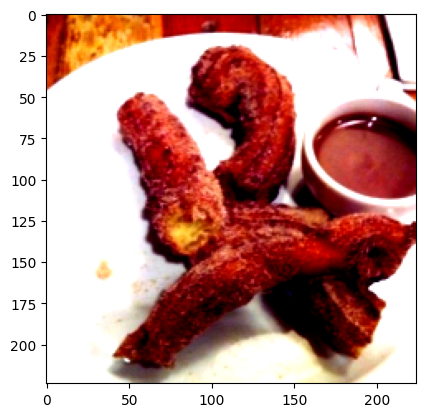

c h u r r o s


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataset)
#images, labels = dataiter.next()
images, labels =next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % train_dataset.classes[label]))

Check the datset is balanced

In [ ]:
from collections import Counter

def get_class_distribution(dataset):
    count_dict = Counter()

    for _, label in dataset:  # Assuming that each data point is a tuple (image, label)
        count_dict[label] += 1

    return count_dict

# Get the class distribution
class_distribution = get_class_distribution(train_dataset)


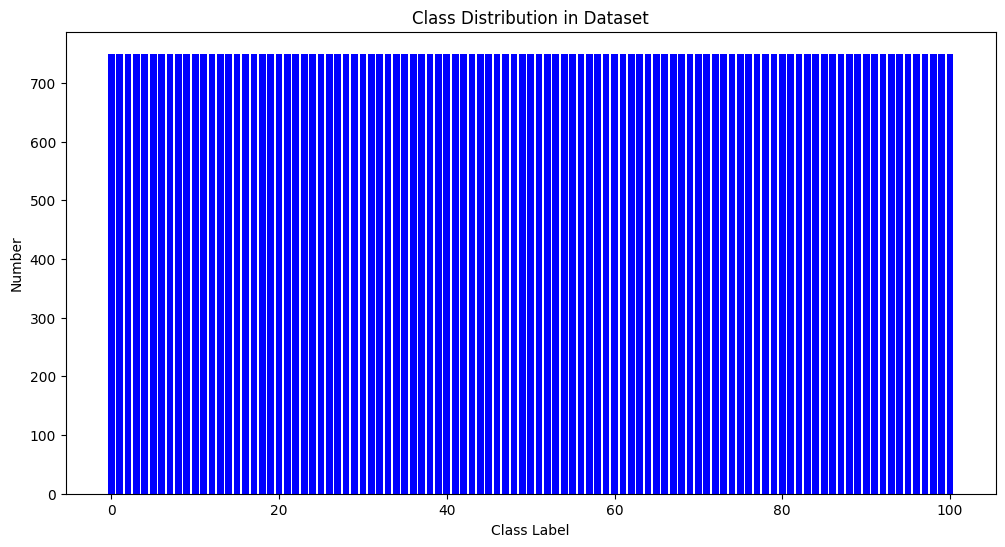

In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(count_dict):
    plt.figure(figsize=(12,6))
    plt.bar(count_dict.keys(), count_dict.values(), color='blue')
    plt.xlabel('Class Label')
    plt.ylabel('Number')
    plt.title('Class Distribution in Dataset')
    plt.show()

# Plot the class distribution
plot_class_distribution(class_distribution)


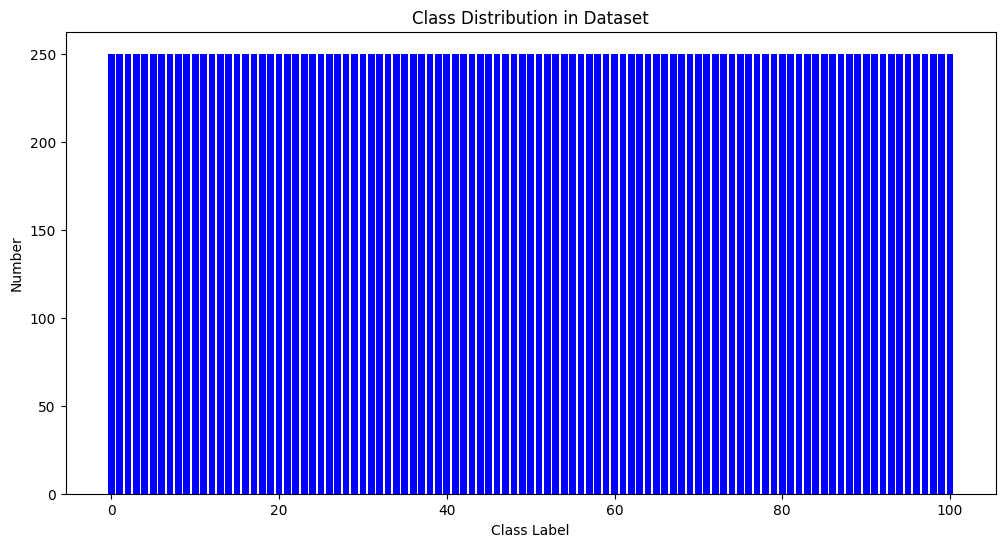

In [ ]:
class_distribution_test = get_class_distribution(test_dataset)
plot_class_distribution(class_distribution_test)

2. Define a Convolutional Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 101)  # Assuming you have 101 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 54 * 54)
        x = self.fc1(x)
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
# Initialize the network
net = Net().to(device)

In [ ]:
# Weight Initialization
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=186624, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=101, bias=True)
)

3. Define a loss function

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

4. Train the network on the training data

In [ ]:
# Training the network
num_epochs = 40

# Initialize lists for recording history
loss_history = []
accuracy_history = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # If you want to track accuracy:
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_predictions / len(train_dataset)  # assuming train_dataset is the full dataset

    loss_history.append(avg_loss)
    accuracy_history.append(epoch_accuracy)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

torch.save(net.state_dict(), 'net.pth')
print('Finished Training')


Epoch 1, Loss: 3.9544, Accuracy: 12.26%
Epoch 2, Loss: 3.9363, Accuracy: 12.60%
Epoch 3, Loss: 3.9227, Accuracy: 12.91%
Epoch 4, Loss: 3.9066, Accuracy: 13.22%
Epoch 5, Loss: 3.8875, Accuracy: 13.64%
Epoch 6, Loss: 3.8768, Accuracy: 13.68%
Epoch 7, Loss: 3.8630, Accuracy: 14.03%
Epoch 8, Loss: 3.8456, Accuracy: 14.27%
Epoch 9, Loss: 3.8321, Accuracy: 14.65%
Epoch 10, Loss: 3.8185, Accuracy: 14.73%
Epoch 11, Loss: 3.8087, Accuracy: 15.00%
Epoch 12, Loss: 3.7925, Accuracy: 15.20%
Epoch 13, Loss: 3.7806, Accuracy: 15.52%
Epoch 14, Loss: 3.7634, Accuracy: 15.89%
Epoch 15, Loss: 3.7559, Accuracy: 15.85%
Epoch 16, Loss: 3.7431, Accuracy: 16.19%
Epoch 17, Loss: 3.7375, Accuracy: 16.29%
Epoch 18, Loss: 3.7203, Accuracy: 16.53%
Epoch 19, Loss: 3.7121, Accuracy: 16.87%
Epoch 20, Loss: 3.6998, Accuracy: 17.06%
Epoch 21, Loss: 3.6872, Accuracy: 17.37%
Epoch 22, Loss: 3.6783, Accuracy: 17.20%
Epoch 23, Loss: 3.6686, Accuracy: 17.47%
Epoch 24, Loss: 3.6538, Accuracy: 17.85%
Epoch 25, Loss: 3.6454, A

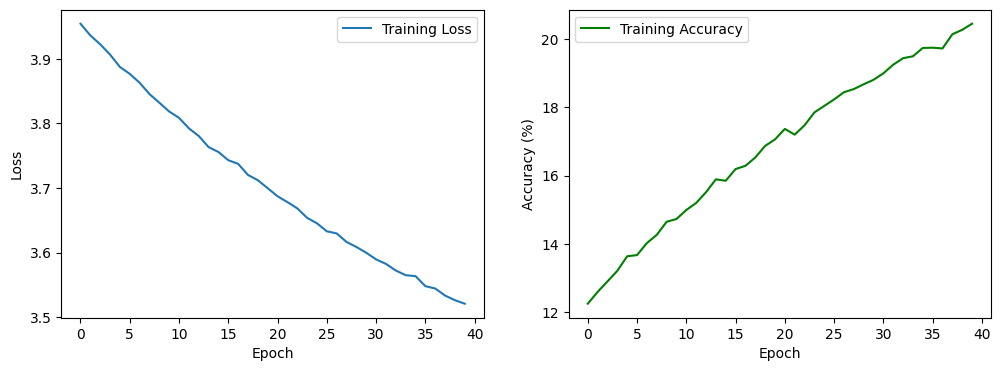

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plotting loss history
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plotting accuracy history
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label="Training Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()


5. Test the network on the test data

In [ ]:
# Set the model to evaluation mode
net.eval()

correct = 0
total = 0

# No need to track gradients for testing
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')


Accuracy of the network on the test images: 26.27%


**Train ResNet**


1.   Load a pre-trained ResNet model from torchvision.models.




In [ ]:
from torchvision.models import resnet50
from torchvision.models.resnet import ResNet50_Weights

# Use weights=None instead of pretrained=False
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 101)  # Adjust the final layer for 101 classes
model = model.to(device)




2. Fine-tune the model using different optimizers
*   Define  a list of otimizers




In [ ]:
#Define a list of optimizers and learning rates to try
optimizer_sgd= torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_adam=torch.optim.Adam(model.parameters(), lr=0.001)
ptimizer_rmsprop=torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer_sgd.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_sgd.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

torch.save(model.state_dict(),'sgd.pth')
print('Finished Training')



[1,  2000] loss: 2.690
[2,  2000] loss: 1.963
[3,  2000] loss: 1.717
[4,  2000] loss: 1.546
[5,  2000] loss: 1.435
[6,  2000] loss: 1.355
[7,  2000] loss: 1.285
[8,  2000] loss: 1.217
[9,  2000] loss: 1.167
[10,  2000] loss: 1.121
Finished Training


In [ ]:
optimizer_rmsprop=torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)
num_epochs = 10


for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer_rmsprop.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_rmsprop.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

torch.save(model.state_dict(), f'{optimizer_rmsprop}.pth')
print('Finished Training')

[1,  2000] loss: 4.604
[2,  2000] loss: 4.157
[3,  2000] loss: 3.847
[4,  2000] loss: 3.632
[5,  2000] loss: 3.475
[6,  2000] loss: 3.338
[7,  2000] loss: 3.220
[8,  2000] loss: 3.105
[9,  2000] loss: 3.021
[10,  2000] loss: 2.939
Finished Training


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer_adam.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_adam.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

torch.save(model.state_dict(), f'{optimizer_adam}.pth')
print('Finished Training')

[1,  2000] loss: 2.709
[2,  2000] loss: 2.621
[3,  2000] loss: 2.592
[4,  2000] loss: 2.560
[5,  2000] loss: 2.538
[6,  2000] loss: 2.520
[7,  2000] loss: 2.498
[8,  2000] loss: 2.486
[9,  2000] loss: 2.466
[10,  2000] loss: 2.449
Finished Training


In [ ]:
# Assuming model is already defined
model.load_state_dict(torch.load('sgd.pth'))
model.to(device)  # ensure model is transferred to the desired device


In [ ]:
import matplotlib.pyplot as plt

num_epochs = 30

# Lists to keep track of training progress:
train_loss_history = []
train_accuracy_history = []

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer_sgd.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_sgd.step()

        # record statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if i % 2000 == 1999:  # print and record every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss_history.append(running_loss / 2000)
            train_accuracy_history.append(100. * correct / total)
            running_loss = 0.0
            correct = 0
            total = 0

torch.save(model.state_dict(), 'sgd_epochs.pth')
print('Finished Training')

[1,  2000] loss: 1.078
[2,  2000] loss: 1.038
[3,  2000] loss: 1.001
[4,  2000] loss: 0.968
[5,  2000] loss: 0.945
[6,  2000] loss: 0.912
[7,  2000] loss: 0.886
[8,  2000] loss: 0.856
[9,  2000] loss: 0.834
[10,  2000] loss: 0.814
[11,  2000] loss: 0.796
[12,  2000] loss: 0.772
[13,  2000] loss: 0.745
[14,  2000] loss: 0.738
[15,  2000] loss: 0.716
[16,  2000] loss: 0.705
[17,  2000] loss: 0.686
[18,  2000] loss: 0.674
[19,  2000] loss: 0.654
[20,  2000] loss: 0.639
[21,  2000] loss: 0.630
[22,  2000] loss: 0.612
[23,  2000] loss: 0.608
[24,  2000] loss: 0.606
[25,  2000] loss: 0.576
[26,  2000] loss: 0.569
[27,  2000] loss: 0.560
[28,  2000] loss: 0.552
[29,  2000] loss: 0.542
[30,  2000] loss: 0.524
Finished Training


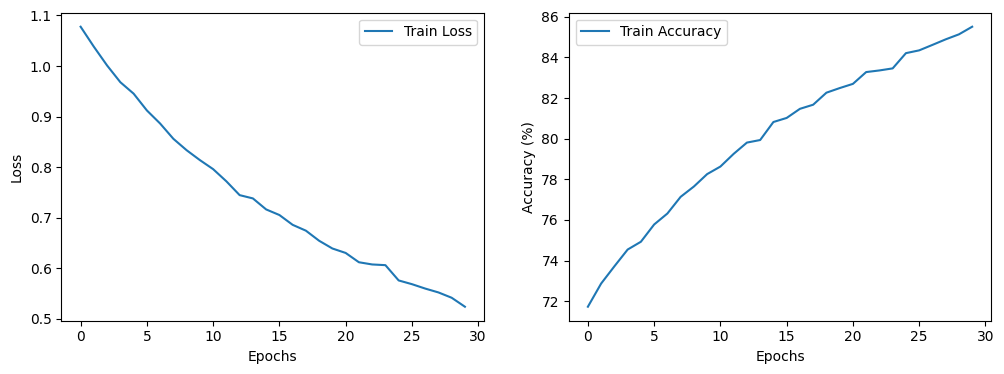

In [ ]:
# Plotting the training progress:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
#To use the saved model weights (sgd_epochs.pth) in the evaluation
#Load the saved weights into your model.
model.load_state_dict(torch.load('sgd_epochs.pth'))

<All keys matched successfully>

In [ ]:
#Make sure that your model is set to evaluation mode using model.eval().
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Accuracy on test set: 84.21%
